In [112]:
import json
import pandas as pd
import pickle
from tqdm import tqdm

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import word_tokenize
import string

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

## 1. Data Collecting

In [68]:
app_packages = [
    'com.traveloka.android'
]

In [69]:
app_infos = []

for application in tqdm(app_packages):
    info = app(application, lang='id', country='id')
    del info['comments']
    app_infos.append(info)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


In [70]:
def print_json(json_object):
    json_str = json.dumps(
        json_object,
        indent=2,
        sort_keys=True,
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [71]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "5.0",
  "androidVersionText": "5.0 dan yang lebih tinggi",
  "appId": "com.traveloka.android",
  "containsAds": false,
  "contentRating": "Rating 3+",
  "contentRatingDescription": null,
  "currency": "IDR",
  "description": "Traveloka hadir dengan wajah baru! Sebagai Lifestyle Super App Asia Tenggara, Traveloka hadir dengan lebih dari 20 produk dan ragam fitur untuk jadi #TemanHidup menguntungkan di segala kebutuhanmu!\r\n\r\nInstall aplikasi Traveloka sekarang dan dapatkan berbagai penawaran spesial mulai dari potongan diskon khusus, Traveloka points gratis, sampai akses ke puluhan game berhadiah menarik hanya untuk kamu!\r\n\r\nPEDULILINDUNGI kini hadir di Traveloka app! Nikmati kemudahan check-in dalam satu aplikasi ke berbagai tempat dengan Safe Entrance by PeduliLindungi di Traveloka App. Traveling makin aman & nyaman dengan Safe Entrance PeduliLindungi di Traveloka App.\r\n\r\nLengkapi harimu dengan akses berbagai pilihan games di Ga

In [72]:
# def format_title(title):
#     sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
#     if sep_index != -1:
#         title = title[:sep_index]
#     return title[:10]

In [73]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

In [74]:
app_reviews = []

for ap in app_packages:
    for score in tqdm(list(range(1,6))):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            rvs, _ = reviews(
                ap,
                lang='id',
                country='id',
                sort=sort_order,
                count=500 if score<=3 else 800,
                filter_score_with=score
            )
            for r in rvs:
                r['sortOrder'] = 'most relevant' if sort_order==Sort.MOST_RELEVANT else 'newest'
                r['appId'] = ap
            app_reviews.extend(rvs)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.66s/it]


In [75]:
app_reviews

[{'reviewId': 'gp:AOqpTOFjAp07iULivueM8eFgIUqd6erex5gWjKFKZIV2u_2fUyt-bAC3TOeh7T6tSASvYGRKoVZPIjaSSc4RN2I',
  'userName': 'Dita Nandasari',
  'userImage': 'https://play-lh.googleusercontent.com/a-/AOh14Ggs4uG0pKfZmNaQwhrW_8E6HzJalISNMRe032op',
  'content': 'Traveloka bagaimana sih, saya sakit ini saya juga harus pulang secepatnya ke serang banten karena adik saya juga sakit. Tolong dong bantu refund pesanan saya, masa pembatalan aja tidak bisa. Pihak hotel aja menyetujuinya kenapa pihak traveloka mempersulitnya. Tolong ya segera di refund saya harus pulang sekarang juga, kalo saya meninggal disini pihak traveloka bisa tanggung jawab ga? Karena uangnya mau saya pakai berobat dan ongkos pulang. TOLONG TOLERANSI DAN HATI NURANI NYA!!!',
  'score': 1,
  'thumbsUpCount': 83,
  'reviewCreatedVersion': '3.45.0',
  'at': datetime.datetime(2021, 12, 26, 14, 37, 21),
  'replyContent': 'Hai, Dita. Mohon maaf untuk ketidaknyamanan yang terjadi. Kami menemukan informasi keluhan Anda sebelumnya dan 

In [76]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOFjAp07iULivueM8eFgIUqd6erex5gWjKFKZIV...,Dita Nandasari,https://play-lh.googleusercontent.com/a-/AOh14...,"Traveloka bagaimana sih, saya sakit ini saya j...",1,83,3.45.0,2021-12-26 14:37:21,"Hai, Dita. Mohon maaf untuk ketidaknyamanan ya...",2021-12-26 15:04:33,most relevant,com.traveloka.android
1,gp:AOqpTOGHqswcGEteFqfTrbW6pFNH8qNghSdG7Jg_IoC...,Yonathan Tanuwidjaja,https://play-lh.googleusercontent.com/a-/AOh14...,"Coba tolong ditindaklanjuti, yang disebut deng...",1,38,3.44.0,2021-12-26 13:38:20,Hai Yonathan. Mimin minta maaf ya kamu jadi ke...,2021-12-26 14:04:42,most relevant,com.traveloka.android
2,gp:AOqpTOG_r1W_X-AJ0dVfT9apQ_cMmRRu5gZs3VO0ZxA...,Shan,https://play-lh.googleusercontent.com/a-/AOh14...,Kenapa yah setiap bikin password gak bisa teru...,1,1,3.44.0,2021-12-27 19:55:51,"Halo, Shan. Saat pembuatan password akan diara...",2021-12-27 20:04:13,most relevant,com.traveloka.android
3,gp:AOqpTOEMKmJbkr829EArjtFhBDQj0o4i0iWBfxnUMa6...,Patricia,https://play-lh.googleusercontent.com/a/AATXAJ...,Kenapa akhir akhir ini traveloka selalu error ...,1,26,3.45.0,2021-12-26 14:53:33,"Halo, Patricia. Mohon maaf untuk ketidaknyaman...",2021-12-26 15:08:32,most relevant,com.traveloka.android
4,gp:AOqpTOHgzJ7nRoZmF2stZWt2cVrafI9L3CQ5hAbwXfd...,Alwie Hamid,https://play-lh.googleusercontent.com/a/AATXAJ...,Paylater di nonaktifkan tanpa ada pemberitahua...,1,2,3.45.0,2021-12-25 05:41:21,Hai kak Alwie. Mohon maaf kak agar dapat Mimin...,2021-12-25 06:04:10,most relevant,com.traveloka.android


In [77]:
app_reviews_df.isna().sum()

reviewId                  0
userName                  0
userImage                 0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    761
at                        0
replyContent            778
repliedAt               778
sortOrder                 0
appId                     0
dtype: int64

In [78]:
app_reviews_df.fillna('No Reply', inplace=True)
app_reviews_df.isna().sum()

reviewId                0
userName                0
userImage               0
content                 0
score                   0
thumbsUpCount           0
reviewCreatedVersion    0
at                      0
replyContent            0
repliedAt               0
sortOrder               0
appId                   0
dtype: int64

In [79]:
app_reviews_df = app_reviews_df.sort_values(['appId', 'at'])
app_reviews_df.to_csv('hasilReviews.csv', index=None, header=True)

## 2. Data Understanding

In [80]:
app_reviews_df.tail()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
3010,gp:AOqpTOHGPfJi2Hezgc-PIEUXiarEDPy9JiHyezqHHxJ...,Pangestu Nadio,https://play-lh.googleusercontent.com/a/AATXAJ...,"Daftar pay later nggak bisa, klik selesain pas...",4,0,3.45.0,2021-12-29 23:20:54,"Halo Pangestu, mohon maaf atas ketidaknyamanan...",2021-12-30 00:14:48,most relevant,com.traveloka.android
3802,gp:AOqpTOHGPfJi2Hezgc-PIEUXiarEDPy9JiHyezqHHxJ...,Pangestu Nadio,https://play-lh.googleusercontent.com/a/AATXAJ...,"Daftar pay later nggak bisa, klik selesain pas...",4,0,3.45.0,2021-12-29 23:20:54,"Halo Pangestu, mohon maaf atas ketidaknyamanan...",2021-12-30 00:14:48,newest,com.traveloka.android
3801,gp:AOqpTOEcRyMVrEzP6sdHr86cLu2CGh8hP5g_83U0sHS...,Ali Mz,https://play-lh.googleusercontent.com/a/AATXAJ...,mantaabek,4,0,3.45.0,2021-12-30 00:35:00,Makasih ya Kak Ali atas penilaiannya. Jika ada...,2021-12-30 01:36:57,newest,com.traveloka.android
500,gp:AOqpTOFlNCKcOi62D5iMEzWuuDRM52x05izVbPUar-k...,Jakob Williyam,https://play-lh.googleusercontent.com/a/AATXAJ...,"Saya pesan tiket tgl 28,12,2021..setelah kita ...",1,0,No Reply,2021-12-30 03:48:43,Mohon maaf atas ketidaknyamanan yang kamu alam...,2021-12-30 04:03:09,newest,com.traveloka.android
3800,gp:AOqpTOFXwFzDwcgX1VwkQYtgnFrg0BVLPgxeQPDo6Nf...,akbar arifin,https://play-lh.googleusercontent.com/a/AATXAJ...,good 👍,4,0,3.45.0,2021-12-30 04:16:00,"Hi, thank you very much for the positive revie...",2021-12-30 04:30:09,newest,com.traveloka.android


In [81]:
#app_reviews_gi_df = app_reviews_df.loc['com.miHoYo.GenshinImpact']
#app_reviews_hi_df = app_reviews_df.loc['com.miHoYo.bh3global']
df_trav = app_reviews_df

In [82]:
app_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 2247 to 3800
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              6200 non-null   object        
 1   userName              6200 non-null   object        
 2   userImage             6200 non-null   object        
 3   content               6200 non-null   object        
 4   score                 6200 non-null   int64         
 5   thumbsUpCount         6200 non-null   int64         
 6   reviewCreatedVersion  6200 non-null   object        
 7   at                    6200 non-null   datetime64[ns]
 8   replyContent          6200 non-null   object        
 9   repliedAt             6200 non-null   object        
 10  sortOrder             6200 non-null   object        
 11  appId                 6200 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 629.7+ KB


In [83]:

app_reviews_trav_januari = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-01']
app_reviews_trav_februari = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-02']
app_reviews_trav_maret = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-03']
app_reviews_trav_april = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-04']

app_reviews_trav_mei = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-05']
app_reviews_trav_juni = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-06']
app_reviews_trav_juli = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-07']
app_reviews_trav_agustus = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-08']

app_reviews_trav_september = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-09']
app_reviews_trav_oktober = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-10']
app_reviews_trav_november = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-11']
app_reviews_trav_desember = app_reviews_df[app_reviews_df['at'].dt.strftime('%Y-%m') == '2021-12']

avg_reviews_trav_januari = app_reviews_trav_januari['score'].mean()
avg_reviews_trav_februari = app_reviews_trav_februari['score'].mean()
avg_reviews_trav_maret = app_reviews_trav_maret['score'].mean()
avg_reviews_trav_april = app_reviews_trav_april['score'].mean()

avg_reviews_trav_mei = app_reviews_trav_mei['score'].mean()
avg_reviews_trav_juni = app_reviews_trav_juni['score'].mean()
avg_reviews_trav_juli = app_reviews_trav_juli['score'].mean()
avg_reviews_trav_agustus = app_reviews_trav_agustus['score'].mean()

avg_reviews_trav_september = app_reviews_trav_september['score'].mean()
avg_reviews_trav_oktober = app_reviews_trav_oktober['score'].mean()
avg_reviews_trav_november = app_reviews_trav_november['score'].mean()
avg_reviews_trav_desember = app_reviews_trav_desember['score'].mean()

print(avg_reviews_trav_september)
print(avg_reviews_trav_oktober)
print(avg_reviews_trav_november)

3.2900552486187844
3.533457249070632
3.3813104189044036


In [84]:
bulan = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni', 'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']
df_new_plot = {
    'Date':bulan,
    'Score':[
        round(avg_reviews_trav_januari, 2),
        round(avg_reviews_trav_februari, 2),
        round(avg_reviews_trav_maret, 2),
        round(avg_reviews_trav_april, 2),
        round(avg_reviews_trav_mei, 2),
        round(avg_reviews_trav_juni, 2),
        round(avg_reviews_trav_juli, 2),
        round(avg_reviews_trav_agustus, 2),
        round(avg_reviews_trav_september, 2),
        round(avg_reviews_trav_oktober, 2),
        round(avg_reviews_trav_november, 2),
        round(avg_reviews_trav_desember, 2),
    ]
}
df_new_plot = pd.DataFrame(df_new_plot)

In [85]:
df_new_plot

,Date,Score
0,Januari,2.39
1,Februari,2.49
2,Maret,2.45
3,April,2.58
4,Mei,2.63
5,Juni,2.68
6,Juli,3.09
7,Agustus,3.48
8,September,3.29
9,Oktober,3.53


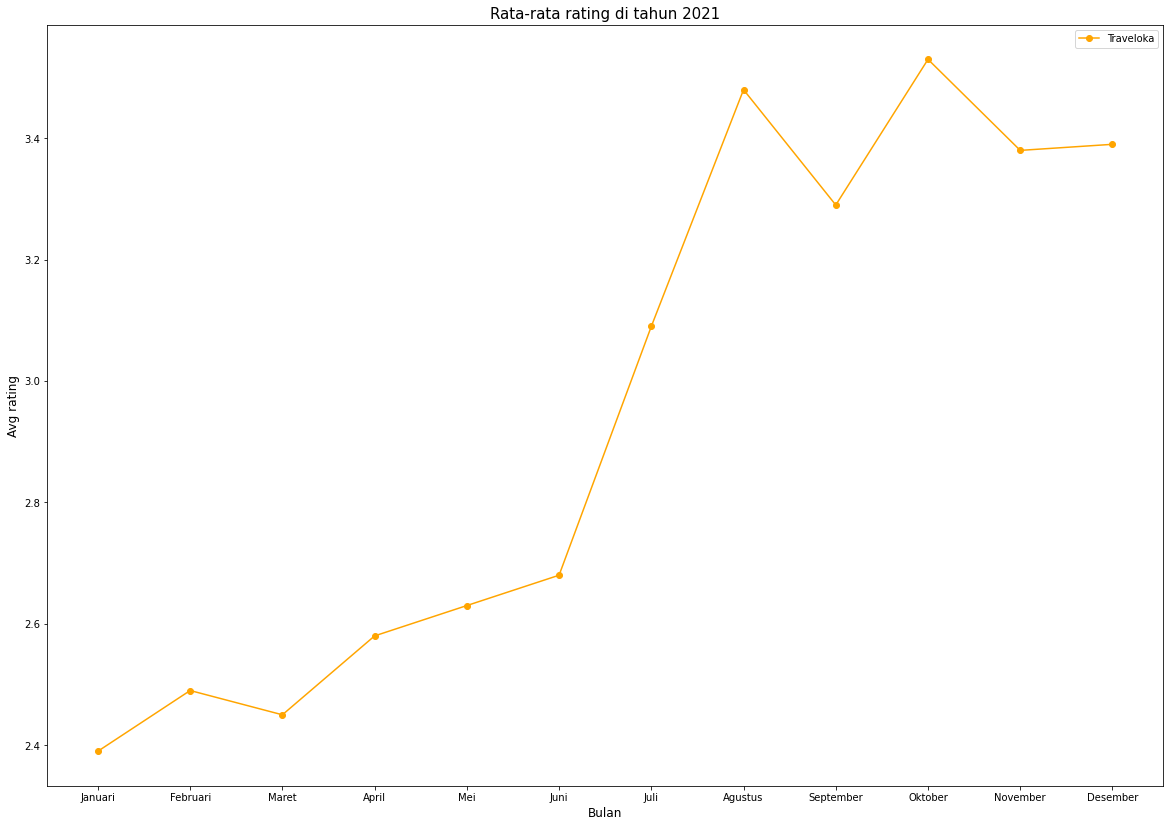

In [86]:
fig = plt.figure(figsize=(20,14))

plt.plot(df_new_plot['Date'], df_new_plot['Score'], label='Traveloka', color='orange', marker='o')
plt.title('Rata-rata rating di tahun 2021', fontsize=15)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Avg rating', fontsize=12)

plt.legend()
plt.show()

## 3. Data preparation

In [87]:
df_trav_sent = app_reviews_df[['content', 'score']]
df_trav_sent.shape

(6200, 2)

In [88]:
df_trav_sent.head()

,content,score
2247,Kalau bisa pemakaian limit paylater jangan di ...,3
2308,Saya sih liat orang pakai ini seru dan mudah c...,3
2373,Saya berkali kali mau daftar paylater kok gak ...,3
1194,Beberapa kali nyoba paylater tp selalu ditolak...,2
3537,Sangat terbantu dgn traveloka ...🌝 pesen tiket...,4


#### Cek missing values

In [89]:
df_trav_sent.isna().sum()

content    0
score      0
dtype: int64

### 3.1. Data labeling

In [90]:
df_trav_sent['sentimen'] = df_trav_sent['score'].apply(lambda x: 'negatif' if x <= 3 else 'positif')

<ipython-input-90-d4650bb72028>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trav_sent['sentimen'] = df_trav_sent['score'].apply(lambda x: 'negatif' if x <= 3 else 'positif')


In [91]:
df_trav_sent.head()

,content,score,sentimen
2247,Kalau bisa pemakaian limit paylater jangan di ...,3,negatif
2308,Saya sih liat orang pakai ini seru dan mudah c...,3,negatif
2373,Saya berkali kali mau daftar paylater kok gak ...,3,negatif
1194,Beberapa kali nyoba paylater tp selalu ditolak...,2,negatif
3537,Sangat terbantu dgn traveloka ...🌝 pesen tiket...,4,positif


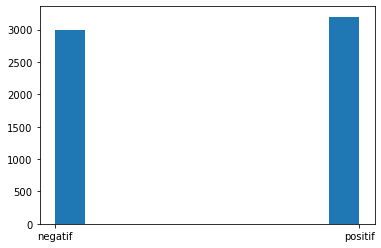

In [92]:
plt.hist(df_trav_sent.sentimen)
plt.show()

In [93]:
df_trav_sent['sentimen'].value_counts()

positif    3200
negatif    3000
Name: sentimen, dtype: int64

### 3.2 Preprocessing

In [94]:
nltk.download('punkt') 
stopwords = StopWordRemoverFactory().get_stop_words()
stemmer = StemmerFactory().create_stemmer()

def lowercase(text):
    return text.lower()

def stemming(text):
    return stemmer.stem(text)

def data_cleansing(text):
    if('bagus' not in text):
        text = text.replace('bagu', 'bagus')
    text = text.replace(' gk ', ' tidak ')
    text = text.replace(' gak ', ' tidak ')
    text = text.replace(' g ', ' tidak ' )
    text = text.replace(' ga ', ' tidak ')
    text = text.replace(' krn ', ' karena ')
    text = text.replace(' blm ', ' belum ')
    text = text.replace(' sdh ', ' sudah ')
    text = text.replace(' klo ',' jika ')
    text = text.replace(' tdk ', ' tidak ')
    text = text.replace(' jgn ', ' jangan ')
    text = text.replace(' skrg ', ' sekarang ')
    text = text.replace(' dgn ', ' dengan ')
    text = text.replace(' emg ', ' memang ')
    text = text.replace(' dpt ', ' dapat ')
    text = text.replace(' ttp ', ' tetap ')
    text = text.replace(' utk ', ' untuk ')
    text = text.replace(' knp ', ' kenapa ')
    text = text.replace(' mkin ', ' semakin ')
    text = text.replace(' dkt ', ' dekat ')
    text = text.replace(' jg ', ' juga ')
    text = text.replace(' jga ', ' juga ')
    text = text.replace(' dr ', ' dari ')
    text = text.replace(' dri ', ' dari ')
    text = text.replace(' bbrp ', ' beberapa ')
    text = text.replace(' bikin ', ' menjadi ')
    text = text.replace("'a", '')
    text = text.replace(' kmr ', ' kamar ')
    text = text.replace(' hrs ', ' harus ')
    text = text.replace(' tmpt ', ' tempat ')
    text = text.replace(' tgl ', ' tanggal ')
    text = text.replace(' org ', ' orang ')
    text = text.replace(' sy ', ' saya ')
    text = text.replace(' sya ', ' saya ')
    text = text.replace(' lg ', ' lagi ')
    text = text.replace(' lgi ', ' lagi ')
    text = text.replace(' jd ', ' jadi ')
    text = text.replace(' jdi ', ' jadi ')
    text = text.replace(' adl ', ' adalah ')
    text = text.replace(' adlah ', ' adalah ')
    text = text.replace(' tp ', ' tapi ')
    text = text.replace(' tpi ', ' tapi ')
    text = text.replace(' mksd ', ' maksud ')
    text = text.replace(' kt ', ' kita ')
    text = text.replace(' kta ', ' kita ')
    text = text.replace(' yg ', ' yang ')
    text = text.replace(' bs ', ' bisa ')
    text = text.replace(' bsa ', ' bisa ')
    text = text.replace(' pesen ', ' pesan ')
    text = text.replace(' nyoba ', ' coba ')
    text = text.replace('tidak bagus', 'jelek')
    text = text.replace('tidak jelek', 'bagus')
    text = text.replace('tidak kecewa', 'suka')
    text = text.replace('tidak suka', 'kecewa')
    text = text.replace('muas', 'puas')
    text = text.replace('tidak puas', 'kecewa')
    word_lst = word_tokenize(text)
    word_lst = [word for word in word_lst if len(word) > 2 and word.isalnum()] # non alfa numerical removing
    word_lst = [word for word in word_lst if string.punctuation not in word] # string punctuition removing
    word_lst = [word for word in word_lst if word not in stopwords] # stopwords removing
    word_lst = [word for word in word_lst if word not in ['kok', 'nya', 'sih']]
    
    text = ' '.join(word_lst)
    return text



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fazri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [95]:
df_trav_sent['content'] = df_trav_sent['content'].apply(lowercase)
df_trav_sent['content'] = df_trav_sent['content'].apply(stemming)
df_trav_sent['content'] = df_trav_sent['content'].apply(data_cleansing)

<ipython-input-95-d744aa83e54b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trav_sent['content'] = df_trav_sent['content'].apply(lowercase)
<ipython-input-95-d744aa83e54b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trav_sent['content'] = df_trav_sent['content'].apply(stemming)
<ipython-input-95-d744aa83e54b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [96]:
df_trav_sent.head()

,content,score,sentimen
2247,kalau pakai limit paylater jangan pakai minima...,3,negatif
2308,liat orang pakai seru mudah cari tiket waktu n...,3,negatif
2373,kali kali mau daftar paylater pdahal tinggal n...,3,negatif
1194,beberapa kali coba paylater selalu tolak padah...,2,negatif
3537,sangat bantu traveloka sen tiket pesawat keret...,4,positif


#### Wordcloud untuk sentimen negatif

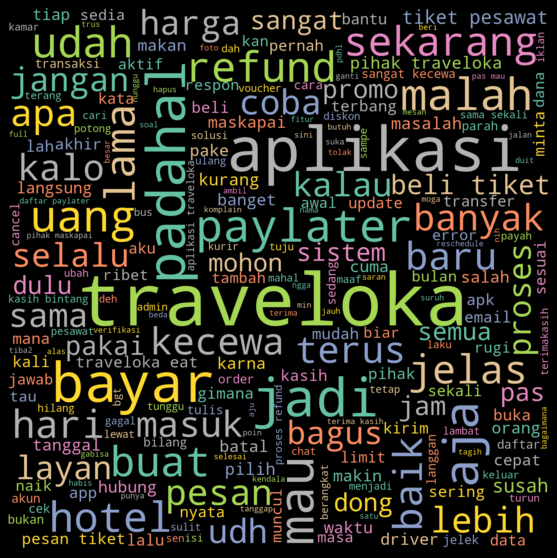

In [97]:
allWordsNegatif = ' '.join([ulasan for ulasan in df_trav_sent[df_trav_sent['sentimen']=='negatif']['content']])
wordCloud = WordCloud(background_color='black', colormap='Set2', width = 1500, height = 1500, random_state=30, max_font_size=200, min_font_size=20, max_words=3000).generate(allWordsNegatif)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Wordcloud untuk sentimen positif

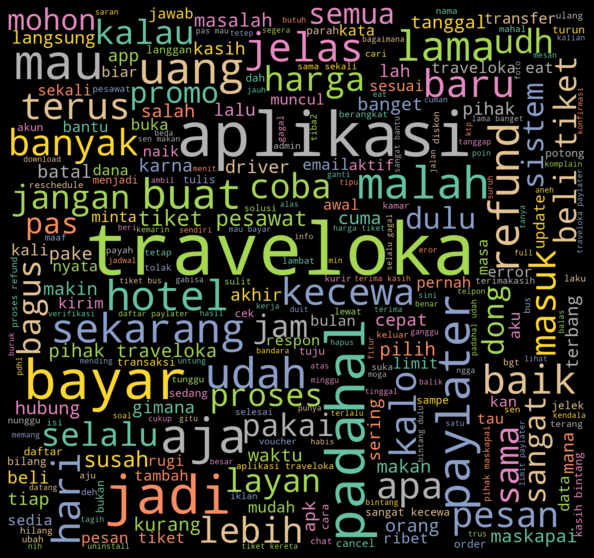

In [98]:
allWordsPositif = ' '.join([ulasan for ulasan in df_trav_sent[df_trav_sent['sentimen']=='positif']['content']])
wordCloud = WordCloud(background_color='black', colormap='Set2', width = 1600, height = 1500, random_state=30, max_font_size=200, min_font_size=20, max_words=3000).generate(allWordsNegatif)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### Splitting data

In [99]:
X_train, X_test, y_train, y_test = train_test_split(df_trav_sent['content'], df_trav_sent['sentimen'], test_size=0.2, random_state=10)

#### Label encoding

In [100]:
from sklearn.preprocessing import LabelEncoder

In [101]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

#### Feature Extraction

In [102]:
vectorize = TfidfVectorizer()
vectorize.fit(df_trav_sent['content'])

X_train_vec = vectorize.transform(X_train)
X_test_vec = vectorize.transform(X_test)

pickle.dump(vectorize, open('tfid.pkl', 'wb'))

In [103]:
X_train_vec.shape

(4960, 5869)

In [104]:
X_test_vec.shape

(1240, 5869)

## 4. Data Modeling

### 4.1. Membangun Model

In [115]:
model = SVC()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

### 4.2. Evaluasi model

In [116]:
print(accuracy_score(y_pred, y_test))
print(recall_score(y_pred, y_test))
print(precision_score(y_pred, y_test))
print(f1_score(y_pred, y_test))

0.8620967741935484
0.8916256157635468
0.8379629629629629
0.863961813842482


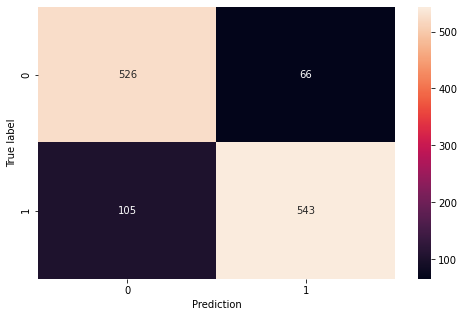

In [118]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Prediction")
plt.ylabel("True label")
plt.show()

### 4.3. Hypertuning parameter

In [119]:
param = {'kernel':('linear', 'rbf'), 'C':[1,100]}
model = SVC()
model_tuned = GridSearchCV(model, param, cv=5)

In [120]:
model_tuned.fit(X_train_vec, y_train)

pickle.dump(model_tuned, open('svc.pkl', 'wb'))

In [121]:
print('Best C ==> ', model_tuned.best_estimator_.C)
print('Best kernel ==> ', model_tuned.best_estimator_.kernel)
print('Best score ==> ', model_tuned.best_score_)

Best C ==>  100
Best kernel ==>  rbf
Best score ==>  0.839717741935484


### 4.4. Penerapan parameter hasil tuning pada model

In [122]:
y_pred = model_tuned.predict(X_test_vec)

print(accuracy_score(y_pred, y_test))
print(recall_score(y_pred, y_test))
print(precision_score(y_pred, y_test))
print(f1_score(y_pred, y_test))

0.8653225806451613
0.8799368088467614
0.8595679012345679
0.8696330991412958


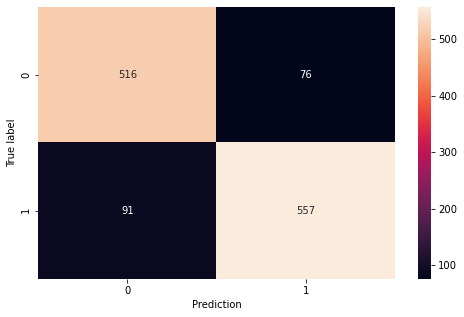

In [123]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("Prediction")
plt.ylabel("True label")
plt.show()

In [111]:
def classify(text):
    text = lowercase(text)
    text = stemming(text)
    text = data_cleansing(text)
    pred = model_tuned.predict(vectorize.transform([text]))
    return pred

classify('tidak bagus aplikasinya')

array([0])